In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from walidacja_funkcji import *

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys]).T

In [193]:
class NF_layer(nn.Module):
    def __init__(self, translate_layers: list[nn.Module], scale_layers: list[nn.Module], lr):
        super().__init__()
        self.translate = nn.Sequential(*translate_layers)
        self.scale = nn.Sequential(*scale_layers)
        self.optim = torch.optim.RMSprop(self.parameters(), lr=lr) # tu nie jestem pewny moze dwa oddzielne optimizery powinny isc idk

        for layer in self.scale:
            if hasattr(layer, 'weight'):
                nn.init.constant_(layer.weight, 1e-5)

        self.to('cuda')

    # mozna dodac loss_backward z funkcja probkowania z NKG
    def loss(self, output: torch.Tensor, log_diag: torch.Tensor = None): 
        return 0.5 * (output ** 2).mean() - log_diag.mean() # No czekaj ale do czego to tak naprawde zmierza

    def loss_and_step(self, output: torch.Tensor, log_diag: torch.Tensor = None):
        self.zero_grad()
        loss = self.loss(output, log_diag)
        loss.backward()
        self.optim.step()
        return loss.item()

    def calculate_forward(self, input: torch.Tensor, function: callable) -> torch.Tensor:
        div_indx = input.shape[-1] // 2
        x1 = input[:, :div_indx]
        x2 = input[:, div_indx:]
        
        scaled = self.scale(x1)
        translated = self.translate(x1)
        diag_sum = scaled # we wzorze jest dzielenie przez N, czyli srednia troche nawet zawyza wynik, ale to chyba dobrze
        x1 = function(x2, scaled, translated)
        z = torch.cat([x2, x1], dim=-1) # swap
        
        return z, diag_sum

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: (x2 + translated) * torch.exp(scaled))

    def inverse(self, input: torch.Tensor) -> torch.Tensor:
        return self.calculate_forward(input, lambda x2, scaled, translated: x2 / torch.exp(scaled) - translated)


class NF(nn.Module):
    def __init__(self, num_layers: int, input_size: int, lr: float):
        super().__init__()

        scaling_components = [
            nn.Linear(input_size, input_size), nn.Tanh(),
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), nn.Tanh(),
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), nn.Tanh(),
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
        ]
        
        translating_components = [
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size), 
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
            nn.Linear(input_size, input_size),
        ]

        self.layers = [NF_layer(translating_components, scaling_components, lr) for _ in range(num_layers)]
        self.to('cuda')
        
    def forward(self, x):
        return self.iterate_layers(x, forward=True, learn=False)
    
    def inverse(self, x):
        return self.iterate_layers(x, forward=False, learn=False)
    
    def loss_and_step(self, x):
        return self.iterate_layers(x, forward=True, learn=True)
    
    def iterate_layers(self, input: torch.Tensor, forward: bool, learn: bool):
        output = input.clone()
        losses = 0
        
        iter_layers = self.layers if forward else reversed(self.layers)
        for layer in iter_layers:
            if forward:
                output, diag_sum = layer.forward(output)
            else:
                output, diag_sum = layer.inverse(output)
            
            if learn:
                # losses += layer.loss(output, diag_sum)
                losses += layer.loss_and_step(output, diag_sum)
                output = output.detach()
        
        if learn:
            return losses

        return output

In [210]:
BATCH_SIZE = 32
PROBES_PER_BATCH = 320
PROBE_SIZE = BATCH_SIZE * PROBES_PER_BATCH
DIMS = PROBES_PER_BATCH // 4
EPOCHS = 400

values = get_2d_data(PROBE_SIZE=PROBE_SIZE).reshape(BATCH_SIZE, -1, 2)
x, y = torch.Tensor(values[:, :, 0]).cuda(), torch.Tensor(values[:, :, 1]).cuda()

loss_history = np.empty(EPOCHS)
x_max, x_mean, x_min = np.empty(EPOCHS), np.empty(EPOCHS), np.empty(EPOCHS)
nf_model = NF(4, DIMS, 1e-5)

nf_model.train()

for epoch in range(EPOCHS):
    print(f'\r{epoch / (EPOCHS - 1) * 100 :.1f}%', end='', flush=True)
    loss_history[epoch] = nf_model.loss_and_step(x)
    y = nf_model.forward(x).detach().cpu().numpy()
    x_max[epoch] = y.max()
    x_min[epoch] = y.min()
    x_mean[epoch] = y.mean()

nf_model.eval()

100.0%

NF()

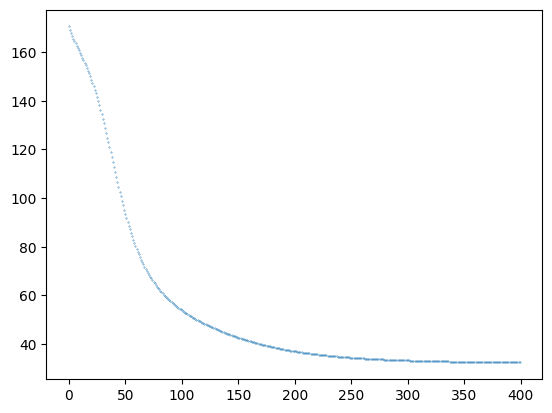

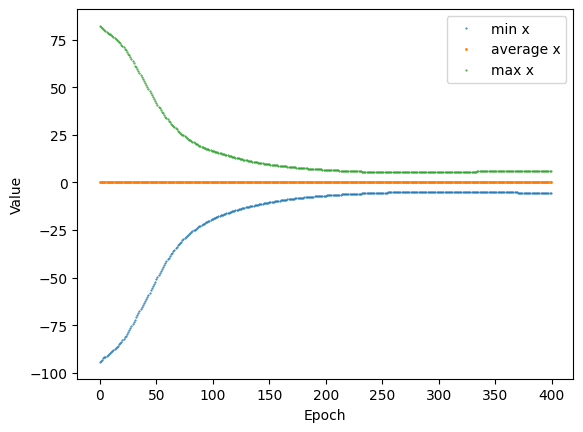

In [211]:
plt.plot(loss_history, 'o', markersize=0.3)
plt.show()

plt.plot(x_min, 'o', markersize=0.5, label='min x')
plt.plot(x_mean, 'o', markersize=1, label='average x')
plt.plot(x_max, 'o', markersize=0.5, label='max x')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()

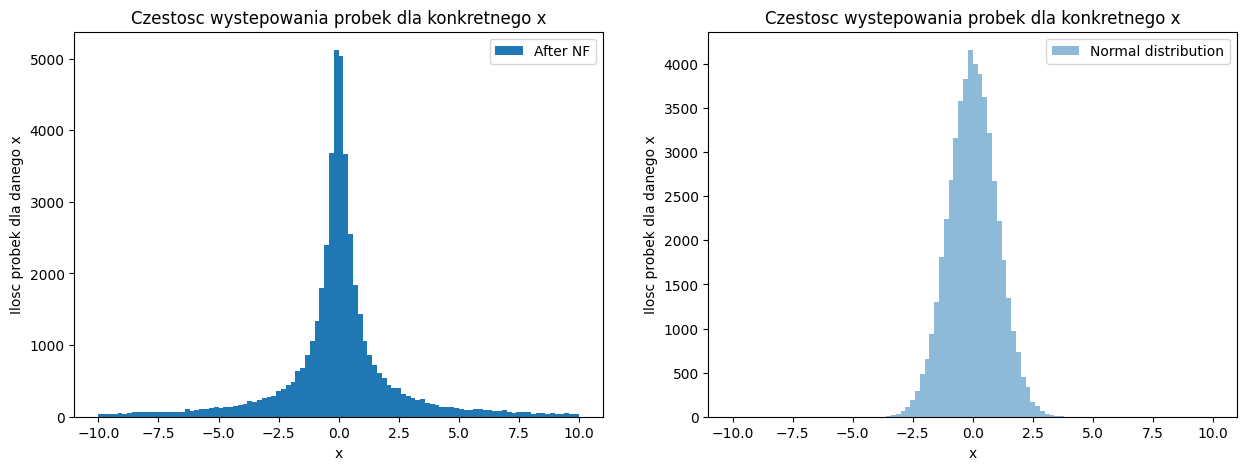

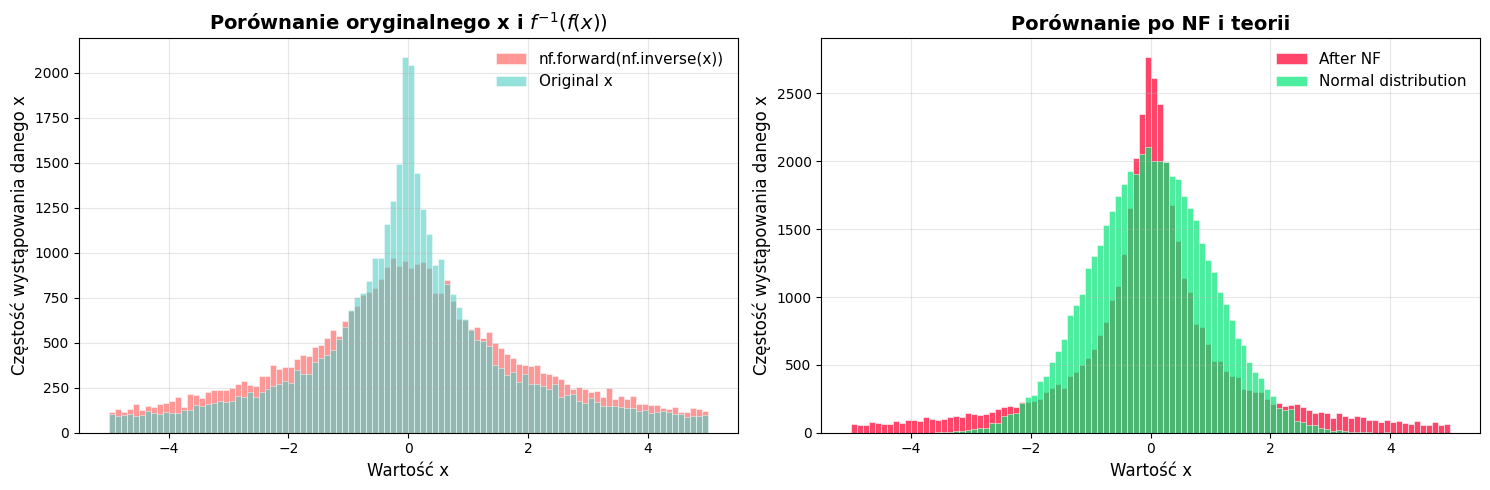

In [212]:
temp = get_2d_data(PROBE_SIZE=PROBE_SIZE * 10).reshape(BATCH_SIZE * 10, -1, 2)
x, y = torch.Tensor(temp[:, :, 0]).cuda(), torch.Tensor(temp[:, :, 1]).cuda()

theory = np.random.randn(PROBE_SIZE * 5)

values = nf_model.forward(x)
inversed = nf_model.inverse(values).detach().flatten().cpu().numpy()
values = values.detach().flatten().cpu().numpy()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title('Czestosc wystepowania probek dla konkretnego x')
_ = ax1.hist(values, bins=100, range=[-10, 10], label='After NF')
ax1.set_xlabel('x')
ax1.set_ylabel('Ilosc probek dla danego x')
ax1.legend()

ax2.set_title('Czestosc wystepowania probek dla konkretnego x')
_ = ax2.hist(theory, bins=100, range=[-10, 10], alpha=0.5, label='Normal distribution')
ax2.set_xlabel('x')
ax2.set_ylabel('Ilosc probek dla danego x')
ax2.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

ax1.set_title(r'Porównanie oryginalnego x i $f^{-1}(f(x))$', fontsize=14, fontweight='bold')
ax1.hist(inversed, bins=100, range=[-5, 5], label='nf.forward(nf.inverse(x))', 
        color=colors[0], alpha=0.7, edgecolor='white', linewidth=0.5)
ax1.hist(x.detach().flatten().cpu().numpy(), bins=100, range=[-5, 5], label='Original x', 
        color=colors[1], alpha=0.6, edgecolor='white', linewidth=0.5)
ax1.set_xlabel('Wartość x', fontsize=12)
ax1.set_ylabel('Częstość wystąpowania danego x', fontsize=12)
ax1.legend(frameon=False, fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.set_title('Porównanie po NF i teorii', fontsize=14, fontweight='bold')
ax2.hist(values, bins=100, range=[-5, 5], label='After NF', 
        color='#FF1744', alpha=0.8, edgecolor='white', linewidth=0.5)  # Czerwony
ax2.hist(theory, bins=100, range=[-5, 5], label='Normal distribution', 
        color='#00E676', alpha=0.7, edgecolor='white', linewidth=0.5)  # Zielony
ax2.set_xlabel('Wartość x', fontsize=12)
ax2.set_ylabel('Częstość wystąpowania danego x', fontsize=12)
ax2.legend(frameon=False, fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

In [213]:
print(f'{values.mean():e}, {values.max():e} {values.min():e}')

1.257947e-01, 9.449559e+02 -5.936705e+02


np.int64(1)